<span style="color:black;font-weight:700;font-size:32px">
            Проект для "Викишоп" с BERT
</span>

https://colab.research.google.com/drive/1VxsOOm5JAbN-Lypp_Sl4YnCOGjEMkaxc?usp=sharing
Ссылка в Colab


<span style="color:black;font-weight:700;font-size:22px">
              Описание проекта
</span>



Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.
Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.
Постройте модель со значением метрики качества F1 не меньше 0.75.\

<span style="color:black;font-weight:700;font-size:22px">
              План работы
 </span>

1) Загрузка данных

2) Подготовка данных

3) Обучение

4) Общий вывод

In [191]:
! pip install torch -q
! pip install transformers -q
! pip install  transformers -q
! pip install lightgbm -q

In [192]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score



# from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

import string
import re


from transformers import BertForSequenceClassification, AdamW, BertConfig, BertTokenizer, BertModel
import torch

from tqdm import notebook
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

pd.set_option('display.max_columns', None)

In [193]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Загрузка данных

In [194]:
try:
    df = pd.read_csv('dataset/toxic_comments.csv', index_col='Unnamed: 0')

except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv',  index_col='Unnamed: 0')

df.head(5)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [195]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


0    143106
1     16186
Name: toxic, dtype: int64

Text(0.5, 1.0, 'Количество токсичных и не токсичных сообщений')

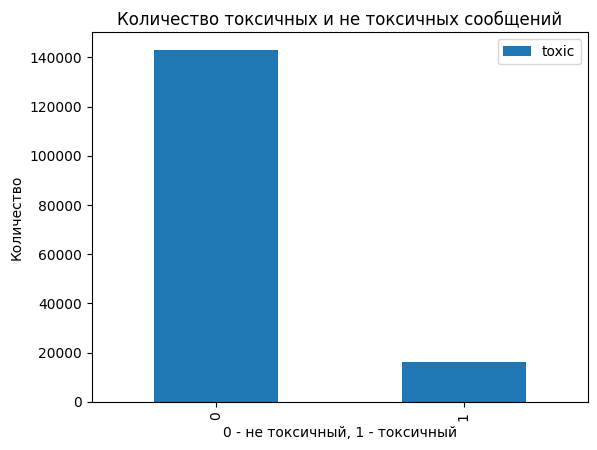

In [196]:
display(df.toxic.value_counts())
df.toxic.value_counts().plot(kind='bar')
plt.legend()
plt.ylabel('Количество')
plt.xlabel('0 - не токсичный, 1 - токсичный')
plt.title('Количество токсичных и не токсичных сообщений')

# Подготовка данных

На этапе подготовки данных предобработаем комментарии выполним лемматизацию текста и удаление стоп-слов и пунктуации.

In [197]:
df_cleaned = df.copy()

In [198]:
def remove_stepwords(text):

    # Паттерн для поиска слов с апострофами
    pattern = r'\b\w+\'\w+\b'
    # Заменяем найденные слова с апострофами на пустую строку
    text = re.sub(pattern, '', text)

    text = re.sub(r'[^a-zA-Z]', ' ', text)

    stop_words = set(stopwords.words('english'))
    tokens = nltk.word_tokenize(text)
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]

    return ' '.join(filtered_tokens)

df_cleaned['text'] = df_cleaned['text'].apply(remove_stepwords)

In [199]:
df_cleaned.head()

,text,toxic
0,Explanation edits made username Hardcore Metal...,0
1,matches background colour seemingly stuck Than...,0
2,Hey man really trying edit war guy constantly ...,0
3,make real suggestions improvement wondered sec...,0
4,sir hero chance remember page,0


In [200]:
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return 'a'  # Adjective
    elif tag.startswith('V'):
        return 'v'  # Verb
    elif tag.startswith('N'):
        return 'n'  # Noun
    elif tag.startswith('R'):
        return 'r'  # Adverb
    else:
        return 'n'  

def lemmatize_text_with_pos(text):
    text = text.lower()
    tokens = word_tokenize(text)
    pos_tags = pos_tag(tokens)
    lemmatized_tokens = [lemmatizer.lemmatize(token, get_wordnet_pos(tag)) for token, tag in pos_tags]
    return ' '.join(lemmatized_tokens)


    

df_cleaned['text'] = df_cleaned['text'].apply(lemmatize_text_with_pos)


In [201]:
df_cleaned.head(5)

,text,toxic
0,explanation edits made username hardcore metal...,0
1,match background colour seemingly stuck thanks...,0
2,hey man really trying edit war guy constantly ...,0
3,make real suggestion improvement wondered sect...,0
4,sir hero chance remember page,0


# Обучение моделей


In [202]:
X = df_cleaned['text']
y = df_cleaned['toxic']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=df_cleaned['toxic'])

## TF-IDF


In [ ]:
stop_words = set(stopwords.words('english'))

pipeline = Pipeline([("vect", TfidfVectorizer(stop_words=list(stop_words))), 
                     ("model", LogisticRegression(random_state=42))])

## LogisticRegression

In [205]:
%%time
lr_parameters_grid = {'model': [LogisticRegression(random_state=42)],
             'model__class_weight': [None, 'balanced'],
             'model__C':  np.linspace(0.0001, 100, 20)
}

random_search = RandomizedSearchCV(
                                 pipeline,
                                 lr_parameters_grid,
                                 cv=3,
                                 n_jobs=-1,
                                 scoring='f1',
                                 random_state=42
                                  )

random_search.fit(X_train, y_train)

print('best parameters: ', random_search.best_params_)
print('best scrores: ', random_search.best_score_)

best parameters:  {'C': 15.789557894736841}
best scrores:  0.7564564088699696


In [206]:
best_lr_model = random_search.best_estimator_
lr_predictions = best_lr_model.predict(tf_idf_test)

In [207]:
print(f'Метрика f1 score модели логистической регрессии: {f1_score(y_test, lr_predictions)}')

Метрика f1 score модели логистической регрессии: 0.7744556724658818


Базовая модель Логистической регрессии показала результат в f1 score - 0.77. Обучим более сложные модели и посмотрим как изменится метрика

## LGBM

In [209]:
%%time
lgbm_parameters_grid = {'model': [LGBMClassifier(class_weight='balanced')],
             'model__n_estimators': [100, 300, 500, 800, 1000]
             
}

grid_search = GridSearchCV(
                                 pipeline,
                                 lgbm_parameters_grid,
                                 cv=3,
                                 n_jobs=-1,
                                 scoring='f1',
                                  )

grid_search.fit(X_train, y_train)

print('best parameters: ', grid_search.best_params_)
print('best scrores: ', grid_search.best_score_)

[LightGBM] [Info] Number of positive: 10845, number of negative: 95880
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 21.018857 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 525965
[LightGBM] [Info] Number of data points in the train set: 106725, number of used features: 9967
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.101616 -> initscore=-2.179393
[LightGBM] [Info] Start training from score -2.179393


In [ ]:
best_lgbm_model = grid_search.best_estimator_
lgbm_predictions = best_lgbm_model.predict(X_test)

In [210]:
print(f'Метрика f1 score модели LGBM: {f1_score(y_test, lgbm_predictions)}')

Метрика f1 score модели LGBM: 0.7438650306748467


## Вывод
Модель логистической регрессии показала лучший результат, чем модель построенная на алгоритме градиентного бустинга

## BERT model

Для дообучения модели BERT возьмем батч размером в 25000 комментариев

In [211]:
batch1 = df.sample(25000)
comments = batch1.text
labels = batch1.toxic

In [212]:
comments_list = comments.tolist()
labels_list = labels.tolist()

In [213]:
torch.cuda.is_available()

True

Загрузим BERT модель

### Загрузка моделей

In [214]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
model = BertModel.from_pretrained('bert-base-uncased')

In [215]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [216]:
max_len = 0

# For every sentence...
for sent in comments:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max comments length: ', max_len)

Token indices sequence length is longer than the specified maximum sequence length for this model (528 > 512). Running this sequence through the model will result in indexing errors


Max comments length:  2142


### Токенезация
Токенезируем слова в комментариях

In [217]:
tokenized = batch1['text'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True))


### Padding
После токенизации, токенизированный текст представляет собой список предложений - каждое предложение представлено как список лексем. Мы хотим, чтобы BERT обрабатывал наши примеры все сразу (как одну партию). Так будет быстрее. По этой причине нам нужно привести все списки к одинаковому размеру, чтобы мы могли представить входные данные в виде одного двумерного массива, а не списка списков (разной длины).

In [218]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

max_len_limit =

# Truncate or pad sequences to the specified max length
padded = np.array([i[:max_len_limit] + [0]*(max_len_limit - len(i[:max_len_limit])) if len(i) < max_len_limit else i[:max_len_limit] for i in tokenized.values])

# Create attention mask based on the updated padded sequences
attention_mask = np.where(padded != 0, 1, 0)


In [219]:
display(np.array(padded).shape)
display(attention_mask.shape)

(25000, 512)

(25000, 512)

### Дообучение BERT

In [220]:
batch_size = 100
embeddings = []

# Assuming model is already on cuda:0
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
    batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]).to(device)
    attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)]).to(device)

    with torch.no_grad():
        batch_embeddings = model(batch, attention_mask=attention_mask_batch)

    embeddings.append(batch_embeddings[0][:, 0, :].cpu().numpy())  # Move back to CPU for numpy conversion if necessary


  0%|          | 0/250 [00:00<?, ?it/s]

In [221]:
features = np.concatenate(embeddings)

In [222]:
model = LogisticRegression(random_state=42)

In [223]:
X = features
y = batch1.toxic

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [224]:
parameters = {'C': np.linspace(0.0001, 100, 20)}
random_search = RandomizedSearchCV(LogisticRegression(),
                                 parameters,
                                 cv=3,
                                 n_jobs=-1,
                                 scoring='f1',
                                 random_state=42)

random_search.fit(X_train, y_train)

print('best parameters: ', random_search.best_params_)
print('best scores: ', random_search.best_score_)

best parameters:  {'C': 5.263252631578947}
best scores:  0.6260524974734282


In [225]:
best_lr_model = random_search.best_estimator_
lr_predictions = best_lr_model.predict(X_test)

In [226]:
print(f'Метрика f1 score модели логистической регрессии на эмбеддингах: {f1_score(y_test, lr_predictions)}')

Метрика f1 score модели логистической регрессии на эмбеддингах: 0.6585875470121186


## Вывод

Модель Логистической регрессии показала худшие результаты на эмбеддингах, полученных с помощью BERT, нежели модель логистической регрессии обученная на TF-IDF.

# Вывод по работе

В рамках данной работы были обучены модели для классификации токсичных комментариев оставленных пользователями в интернет - магазине Викишоп.

Лучшие результаты на тестовой выборке показал модель логистической регрессии, на вход которой подавались преобразованные TF-IDF комментарии, метрика F1 = 0.77

Модель логистической регрессии обученная на эмбеддингах полученных моделью BERT, показала менее точные результаты - F1 = 0.65

 **Чек-лист проверки**
- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны